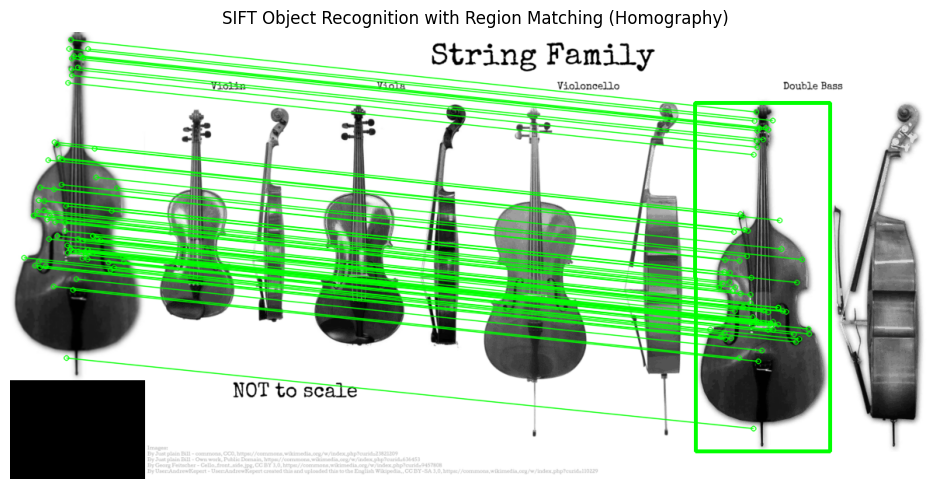

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
query_img = cv2.imread('doublebass.png', cv2.IMREAD_GRAYSCALE)  # Object image
scene_img = cv2.imread('string_family.png', cv2.IMREAD_GRAYSCALE)   # Scene containing object

if query_img is None or scene_img is None:
    raise ValueError("Could not load images. Check file paths.")

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints1, descriptors1 = sift.detectAndCompute(query_img, None)
keypoints2, descriptors2 = sift.detectAndCompute(scene_img, None)

# Use FLANN-based matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# Apply ratio test to keep good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Minimum number of matches required for homography
MIN_MATCH_COUNT = 10

if len(good_matches) > MIN_MATCH_COUNT:
    # Get keypoints coordinates
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Compute Homography using RANSAC
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Use mask to filter inliers
    matchesMask = mask.ravel().tolist()

    # Get the object’s bounding box in the original image
    h, w = query_img.shape
    object_corners = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)

    # Transform object corners to scene image
    detected_corners = cv2.perspectiveTransform(object_corners, M)

    # Draw the detected object region
    scene_img_colored = cv2.cvtColor(scene_img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(scene_img_colored, [np.int32(detected_corners)], isClosed=True, color=(0, 255, 0), thickness=3)

else:
    print("Not enough matches found - {}/{}".format(len(good_matches), MIN_MATCH_COUNT))
    matchesMask = None

# Draw matches with inliers
draw_params = dict(matchColor=(0, 255, 0), singlePointColor=None, matchesMask=matchesMask, flags=2)
result_img = cv2.drawMatches(query_img, keypoints1, scene_img_colored, keypoints2, good_matches, None, **draw_params)

# Convert BGR to RGB for Matplotlib
result_img_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

# Display result in Jupyter Notebook
plt.figure(figsize=(12, 6))
plt.imshow(result_img_rgb)
plt.axis('off')  # Hide axis
plt.title("SIFT Object Recognition with Region Matching (Homography)")
plt.show()


Test Accuracy: 0.7250


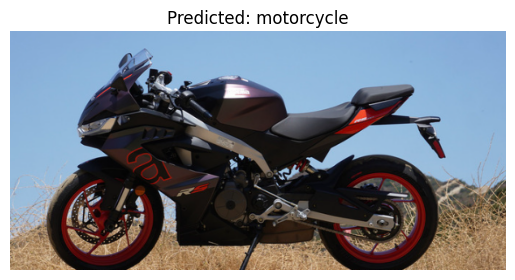

In [24]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define dataset path (update with your dataset location)
dataset_path = r"C:\SEM - 4\Dataset"
class_names = ["Car", "motorcycle", "Truck", "Bus"]

# Function to extract HOG features
def extract_hog_features(image):
    # Resize image to a fixed size (optional, ensures consistency)
    image = cv2.resize(image, (128, 128))  
    # Extract HOG features
    features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9, visualize=True)
    return features

# Load dataset
features = []
labels = []

for class_idx, class_name in enumerate(class_names):
    class_folder = os.path.join(dataset_path, class_name)

    if not os.path.exists(class_folder):
        print(f"Warning: Folder '{class_folder}' not found!")
        continue

    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Warning: Unable to read '{img_path}'")
            continue

        # Extract HOG features
        hog_features = extract_hog_features(img)
        features.append(hog_features)
        labels.append(class_idx)

# Convert to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train an SVM classifier
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Predict on test data
y_pred = svm_model.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Function to classify a new image
def classify_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Error: Unable to read image '{image_path}'")
        return

    hog_features = extract_hog_features(img).reshape(1, -1)
    prediction = svm_model.predict(hog_features)
    predicted_class = class_names[prediction[0]]

    # Show image with predicted label
    plt.imshow(cv2.imread(image_path)[:, :, ::-1])
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

# Example test
classify_image(r"test1.png")
